## Using MOC files of the VAST Pilot Survey

This notebook gives an example of how to use vast-tools in a notebook environment to interact with the MOC, or STMOC, files of the VAST Pilot survey.

MOC stands for `Multi-Order Coverage map` as is a standard in astronomy for showing survey coverage, see this link for a tutorial on HiPS and MOCS:

* http://cds.unistra.fr/adass2018/

I also recommened looking at the mocpy docs, as all interaction with the mocs here is performed using mocpy:

* https://cds-astro.github.io/mocpy/

Below are the imports required for this example. The main import required from vast-tools is the VASTMOCS class. Astropy objects are also imported, as well as `matplotlib.pyplot`. Also imported is `World2ScreenMPL` from mocpy which allows us to create `wcs` objects on which we can plot MOC coverages (see https://cds-astro.github.io/mocpy/examples/examples.html).

In [1]:
from vasttools.moc import VASTMOCS
from astropy.time import Time
from mocpy import World2ScreenMPL
import matplotlib.pyplot as plt
from astropy import units as u
from astropy.coordinates import Angle, SkyCoord

Included in VASTMOCS are:

* A MOC file for each pilot survey epoch.
* A MOC file for each pilot survey field.
* A STMOC for the current VAST Pilot Survey (this is a MOC file with observation time information attached).

The first task is to initialise a VASTMOCS object:

In [2]:
vast_mocs = VASTMOCS()

### Field MOCS

Let's start by loading and plotting a MOC of a field, which is loaded as below. We will load both the `TILES` and `COMBINED` version and plot both to see the difference between the two.

In [3]:
field_moc = vast_mocs.load_pilot_field_moc('VAST_0012-06A', itype='tiles')
field_moc_comb = vast_mocs.load_pilot_field_moc('VAST_0012-06A', itype='combined')

As stated in the mocpy documentation, in order to plot a MOC file we need to use `World2ScreenMPL`. This is done below. For convenience we also load a dataframe containing field centres which is available in vast-tools.

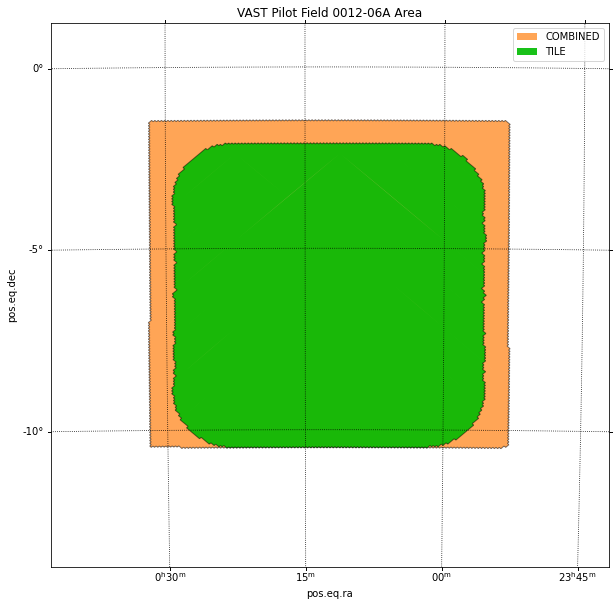

In [4]:
from vasttools.survey import FIELD_CENTRES
# set the field name as the index for convenience
FIELD_CENTRES = FIELD_CENTRES.set_index('field')

fig = plt.figure(figsize=(10,10))

with World2ScreenMPL(
    fig,
    fov=15 * u.deg,
    center=SkyCoord(
        FIELD_CENTRES.loc['VAST_0012-06A']['centre-ra'], 
        FIELD_CENTRES.loc['VAST_0012-06A']['centre-dec'], unit='deg', frame='icrs'
    ),
    coordsys="icrs",
    rotation=Angle(0, u.degree),
) as wcs:
    ax = fig.add_subplot(111, projection=wcs)
    ax.set_title("VAST Pilot Field 0012-06A Area")
    ax.grid(color="black", linestyle="dotted")
    field_moc_comb.fill(ax=ax, wcs=wcs, alpha=0.7, fill=True, linewidth=0, color="C1", label='COMBINED')
    field_moc_comb.border(ax=ax, wcs=wcs, alpha=0.5, color="black")
    field_moc.fill(ax=ax, wcs=wcs, alpha=0.9, fill=True, linewidth=0, color="#00bb00", label='TILE')
    field_moc.border(ax=ax, wcs=wcs, alpha=0.5, color="black")
        
plt.legend()
plt.show()

You can also combine MOC files to create a new MOC, below I load the field to the North and add it to the already loaded field above.

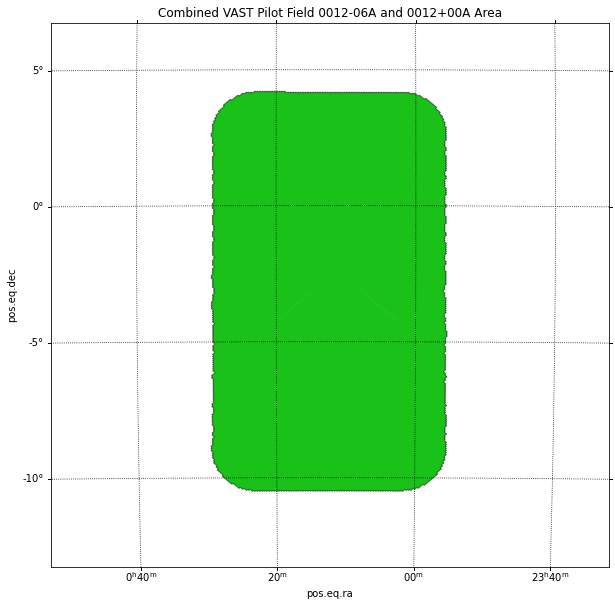

In [5]:
# Load moc to the north
north_field_moc = vast_mocs.load_pilot_field_moc('VAST_0012+00A', itype='tiles')

# Add the mocs together
sum_moc = field_moc.union(north_field_moc)

fig = plt.figure(figsize=(10,10))

with World2ScreenMPL(
    fig,
    fov=20. * u.deg,
    center=SkyCoord(
        FIELD_CENTRES.loc['VAST_0012-06A']['centre-ra'], 
        FIELD_CENTRES.loc['VAST_0012-06A']['centre-dec'] + 3, unit='deg', frame='icrs'
    ),
    coordsys="icrs",
    rotation=Angle(0, u.degree),
) as wcs:
    ax = fig.add_subplot(111, projection=wcs)
    ax.set_title("Combined VAST Pilot Field 0012-06A and 0012+00A Area")
    ax.grid(color="black", linestyle="dotted")
    sum_moc.fill(ax=ax, wcs=wcs, alpha=0.9, fill=True, linewidth=0, color="#00bb00")
    sum_moc.border(ax=ax, wcs=wcs, alpha=0.5, color="black")
        
plt.show()

### Epoch MOCS

Epoch MOCS are loaded and manipulated in the same way.

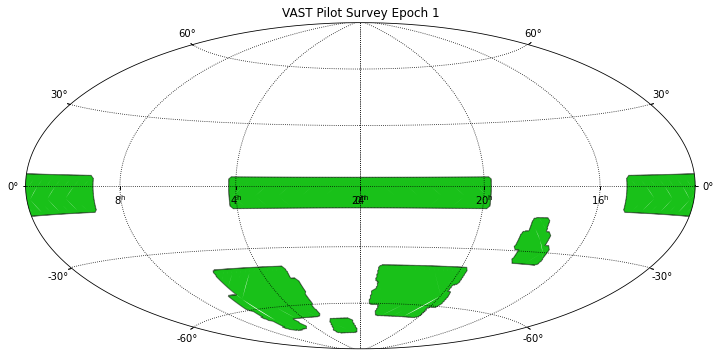

In [6]:
from astropy.visualization.wcsaxes.frame import EllipticalFrame

epoch1_moc = vast_mocs.load_pilot_epoch_moc('1')

fig = plt.figure(figsize=(12, 6))

with World2ScreenMPL(
    fig,
    fov=320 * u.deg,
    center=SkyCoord(0, 0., unit='deg', frame='icrs'),
    coordsys="icrs",
    rotation=Angle(0, u.degree),
) as wcs:
    ax = fig.add_subplot(111, projection=wcs, frame_class=EllipticalFrame)
    ax.set_title("VAST Pilot Survey Epoch 1")
    ax.grid(color="black", linestyle="dotted")
    epoch1_moc.fill(ax=ax, wcs=wcs, alpha=0.9, fill=True, linewidth=0, color="#00bb00")
    epoch1_moc.border(ax=ax, wcs=wcs, alpha=0.5, color="black")
        
plt.show()

### VAST Pilot STMOC

The STMOC (a Space-Time MOC) file is a MOC file containing the current entire VAST Pilot survey with time information attached. You can use it to match survey areas that are time sensitive. In the example below we query 4 time ranges and plot the coverage of the Pilot survey within these time ranges, example taken from the mocpy example notebook (https://github.com/cds-astro/mocpy/blob/master/notebooks/Space%20%26%20Time%20coverages.ipynb).

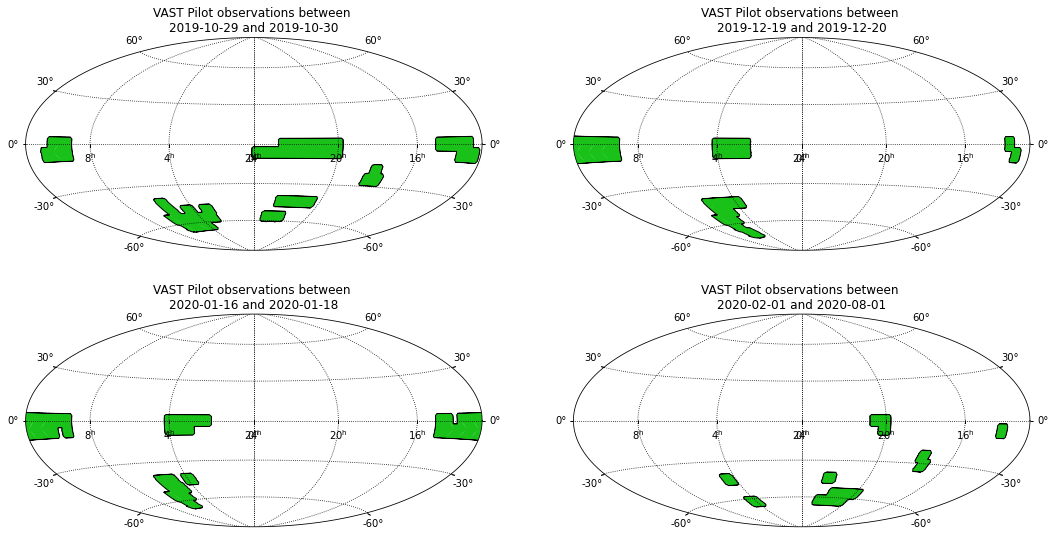

In [7]:
# load the stmoc
vast_stmoc = vast_mocs.load_pilot_stmoc()

def add_to_plot(fig, id, wcs, title, moc):
    ax = fig.add_subplot(id, projection=wcs, frame_class=EllipticalFrame)

    ax.grid(color="black", linestyle="dotted")
    ax.set_title(title)
    ax.set_xlabel('lon')
    ax.set_ylabel('lat')

    moc.fill(ax=ax, wcs=wcs, alpha=0.9, fill=True, linewidth=0, color="#00bb00")
    moc.border(ax=ax, wcs=wcs, linewidth=1, color="black")

fig = plt.figure(figsize=(18, 9))
plt.subplots_adjust(hspace=0.3)

time_ranges = Time([
        [["2019-10-29", "2019-10-30"]],
        [["2019-12-19", "2019-12-20"]],
        [["2020-01-16", "2020-01-18"]],
        [["2020-02-01", "2020-08-01"]]
    ], format='iso', scale='tdb', out_subfmt="date")
with World2ScreenMPL(fig, 
         fov=320 * u.deg,
         center=SkyCoord(0, 0, unit='deg', frame='icrs'),
         coordsys="icrs",
         rotation=Angle(0, u.degree),
         projection="AIT") as wcs:

    for i in range(0, 4):
        moc_vast = vast_stmoc.query_by_time(time_ranges[i])
        title = "VAST Pilot observations between \n{0} and {1}".format(time_ranges[i][0, 0].iso, time_ranges[i][0, 1].iso)
        id_subplot = int("22" + str(i+1))
        add_to_plot(fig, id_subplot, wcs, title, moc_vast)

plt.show()